In [1]:
pip install pdfminer3k

Note: you may need to restart the kernel to use updated packages.


In [7]:
from pdfminer.pdfinterp import PDFResourceManager, process_pdf
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO
from io import open
from urllib.request import urlopen
import re
import os

In [8]:
def read_pdf_file(pdfFile):
    pdfrm = PDFResourceManager()
    strio = StringIO()
    lapa = LAParams()
    device = TextConverter(pdfrm, strio, laparams = lapa)
    
    process_pdf(pdfrm, device, pdfFile)
    device.close()
    
    content = strio.getvalue()
    strio.close()
    return content

In [9]:
pdf_samsung = open("삼성디스플레이.pdf", "rb")
samsung_display = read_pdf_file(pdf_samsung)
pdf_samsung.close() 

pdf_skens = open("SK E&S.pdf", "rb")
sk_ens = read_pdf_file(pdf_skens)
pdf_skens.close()

pdf_skens = open("SK머티리얼즈.pdf", "rb")
sk_muti = read_pdf_file(pdf_skens)
pdf_skens.close()

pdf_skens = open("아시아문화원.pdf", "rb")
sk_asia = read_pdf_file(pdf_skens)
pdf_skens.close()

pdf_skens = open("현대로템.pdf", "rb")
sk_hyun = read_pdf_file(pdf_skens)
pdf_skens.close()

In [10]:
from konlpy.tag import Mecab
mecab = Mecab()

tokens = []
def word_token (x) :
    for token in mecab.pos(x):
        tokens.append(token)
    return tokens

word_token(samsung_display)
word_token(sk_ens)
word_token(sk_muti)
word_token(sk_asia)
word_token(sk_hyun)

[('SAMSUNG', 'SL'),
 ('DISPLAY', 'SL'),
 ('Sustainability', 'SL'),
 ('Report', 'SL'),
 ('2021', 'SN'),
 ('SEE', 'SL'),
 ('THROUGH', 'SL'),
 ('', 'SY'),
 ('', 'SY'),
 ('우리', 'NP'),
 ('는', 'JX'),
 ('SEE', 'SL'),
 ('THROUGH', 'SL'),
 ('지속', 'NNG'),
 ('가능', 'NNG'),
 ('한', 'XSA+ETM'),
 ('내일', 'NNG'),
 ('을', 'JKO'),
 ('봅니다', 'VV+EC'),
 ('', 'SY'),
 ('', 'SY'),
 ('세상', 'NNG'),
 ('을', 'JKO'),
 ('바라본다는', 'VV+ETM'),
 ('것', 'NNB'),
 ('단순히', 'MAG'),
 ('보', 'VV'),
 ('는', 'ETM'),
 ('것', 'NNB'),
 ('만', 'JX'),
 ('이', 'JKC'),
 ('아닙니다', 'VCN+EF'),
 ('그', 'MM'),
 ('속', 'NNG'),
 ('에서', 'JKB'),
 ('우리', 'NP'),
 ('를', 'JKO'),
 ('발견', 'NNG'),
 ('하', 'XSV'),
 ('고', 'EC'),
 ('더', 'MAG'),
 ('나아가', 'VV'),
 ('서', 'EC'),
 ('함께', 'MAG'),
 ('살아가', 'VV'),
 ('야', 'EC'),
 ('할', 'VX+ETM'),
 ('지구촌', 'NNG'),
 ('가족', 'NNG'),
 ('을', 'JKO'),
 ('봅니다', 'VV+EC'),
 ('', 'SY'),
 ('', 'SY'),
 ('세상', 'NNG'),
 ('을', 'JKO'),
 ('보여', 'VV+EC'),
 ('준다는', 'VX+ETM'),
 ('것', 'NNB'),
 ('단순히', 'MAG'),
 ('보여', 'VV+EC'),
 ('주', 'VX'),
 ('는', 'E

In [11]:
from konlpy.tag import Mecab
mecab = Mecab()
stop = ["삼성", "디스플레이", "관리"]
tokens = [token for token in mecab.pos(samsung_display)]

nodes = [t[0] for t in tokens]
vocab = [t[0] for t in tokens if t[0] not in stop if t[1] in ['NNG', 'NNP'] and len(t[0]) > 1]

print(nodes[:10])
print(vocab[:10])


['SAMSUNG', 'DISPLAY', 'Sustainability', 'Report', '2021', 'SEE', 'THROUGH', '', '', '우리']
['지속', '가능', '내일', '세상', '발견', '지구촌', '가족', '세상', '무한', '가능']


In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

count = Counter(vocab)
words = dict(count.most_common())

In [13]:
%matplotlib inline 
import matplotlib 
from IPython.display import set_matplotlib_formats 
matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)


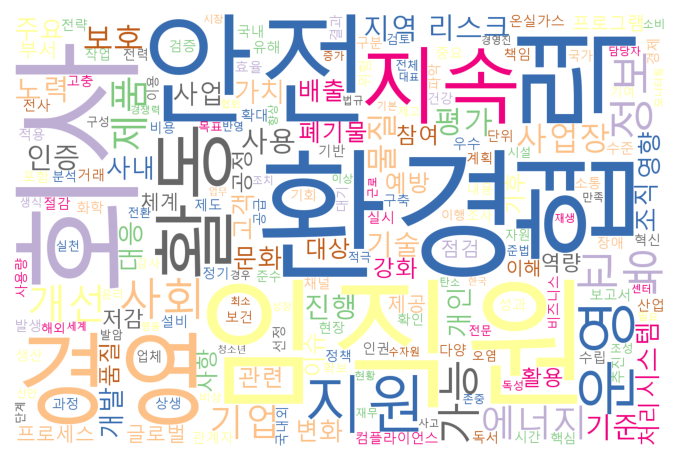

In [14]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

In [15]:
vocab = list(set(vocab))

vocab2idx = {vocab[i]:i for i in range(len(vocab))}
idx2vocab = {i:vocab[i] for i in range(len(vocab))}

In [16]:
import numpy as np
import math

vocab_len = len(vocab2idx)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len,vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 4
covered_coocurrences = []

for window_start in range(len(nodes) - window_size + 1):
    window = nodes[window_start:window_start+window_size]
    for i in range(window_size):
        for j in range(i+1, window_size):
            if window[i] in vocab and window[j] in vocab:
                index_i = window_start + i
                index_j = window_start + j

                if (index_i, index_j) not in covered_coocurrences:
                    weighted_edge[vocab2idx[window[i]]][vocab2idx[window[j]]] = 1
                    weighted_edge[vocab2idx[window[j]]][vocab2idx[window[i]]] = 1
                    covered_coocurrences.append((index_i, index_j))

for i in range(vocab_len):
    row_sum = weighted_edge[i].sum()
    weighted_edge[i] = weighted_edge[i]/row_sum if row_sum > 0 else 0

MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(MAX_ITERATIONS):
    prev_score = np.copy(score)

    for i in range(vocab_len):
        summation = 0
        for j in range(vocab_len):
            if weighted_edge[j][i] != 0:
                summation += weighted_edge[j][i] * prev_score[j]

        score[i] = (1 - d) * d*summation

    if np.sum(np.fabs(prev_score -  score)) <= threshold:
        break


sorted_index = np.flip(np.argsort(score), 0)

n = 50


print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
환경 : 2.0532282e-08
임직원 : 1.9838414e-08
안전 : 1.8050772e-08
운영 : 1.7436182e-08
회사 : 1.7077904e-08
활동 : 1.6829931e-08
지원 : 1.6536386e-08
교육 : 1.5919987e-08
협력 : 1.5456763e-08
개선 : 1.5261017e-08
정보 : 1.4246694e-08
경영 : 1.3577339e-08
지속 : 1.3277584e-08
제품 : 1.2812051e-08
사회 : 1.235914e-08
사업장 : 1.2165068e-08
가능 : 1.1660423e-08
사용 : 1.1406237e-08
기업 : 1.1288607e-08
기술 : 1.1235045e-08
지역 : 1.1024713e-08
사내 : 1.0688035e-08
보호 : 1.06716636e-08
기준 : 1.0501031e-08
관련 : 1.0492387e-08
에너지 : 1.0374051e-08
사업 : 1.0106215e-08
평가 : 1.0081555e-08
산안 : 1.0059255e-08
인증 : 9.2782635e-09
조직 : 9.23292e-09
대응 : 9.225745e-09
문화 : 9.183638e-09
주요 : 9.119972e-09
개발 : 9.029304e-09
물질 : 8.973046e-09
진행 : 8.914113e-09
프로세스 : 8.906623e-09
대상 : 8.895576e-09
예방 : 8.879608e-09
강화 : 8.608413e-09
사항 : 8.547235e-09
고객 : 8.521923e-09
다양 : 8.512289e-09
개인 : 8.168265e-09
리스크 : 8.141652e-09
노력 : 8.103067e-09
공정 : 8.0857525e-09
시스템 : 7.990379e-09
기반 : 7.680617e-09


In [17]:
keyword = []
for i in range(0,15):
    keyword.append(str(idx2vocab[sorted_index[i]]))


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_topic = 3

tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(keyword)
svd = TruncatedSVD(n_components=n_topic, n_iter=100)

U = svd.fit_transform(tfidf)
Vt = svd.components_

In [19]:
vocab = tfidf_vect.get_feature_names()
print(vocab)
n = 3
for i, topic in enumerate(Vt):
    print("Topic {}".format(i), [ (vocab[i], topic[i], round(3)) for i in topic.argsort()[:-n-1:-1]])

['개선', '경영', '교육', '사회', '안전', '운영', '임직원', '정보', '제품', '지속', '지원', '협력', '환경', '활동', '회사']
Topic 0 [('협력', 0.5860034506358958, 3), ('개선', 0.39955845694120357, 3), ('지속', 0.28817583932746205, 3)]
Topic 1 [('협력', 0.5319916759354075, 3), ('환경', 0.32110489322311137, 3), ('교육', 0.2184230627726464, 3)]
Topic 2 [('환경', 0.4829189342932124, 3), ('지원', 0.45378901255141585, 3), ('사회', 0.278534982699788, 3)]


In [20]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def calc_simiarlty_matrix(vectors):
    def consine_similarity(a,b):
        return dot(a,b)/(norm(a)*norm(b))
    
    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word, n_word))
    
    for i in range(n_word):
        for j in range(n_word):
            similarity_matrix[j, i] = consine_similarity(vectors[i], vectors[j]).round(4)

    return similarity_matrix

In [21]:
word_vectors = Vt.T
word_similarity_matrix = calc_simiarlty_matrix(word_vectors)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity(similarity_matrix, label):
    mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rc('font', family='Malgun Gothic')
    ax = sns.heatmap(similarity_matrix, mask=mask, xticklabels=label, yticklabels=label,
                     annot=True, fmt=".2f", annot_kws={"size":8},cmap="coolwarm")

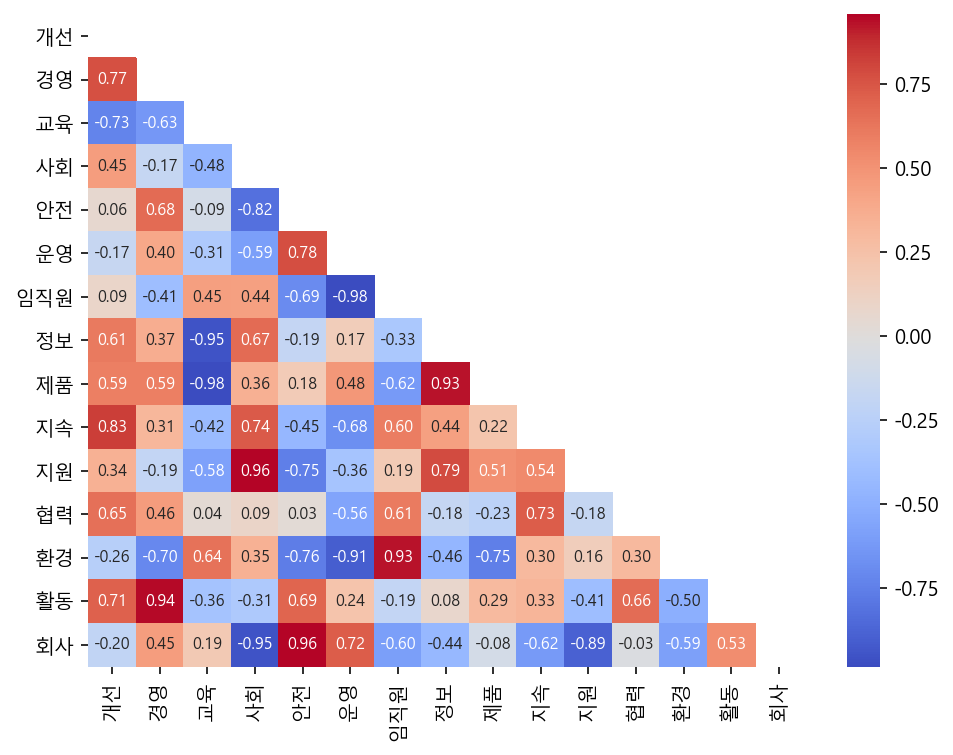

In [24]:
visualize_similarity(word_similarity_matrix, vocab)

In [25]:
from sklearn.manifold import TSNE

def visualize_vectors(vectors, labels):
    tsne = TSNE(n_components=2, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(T[:,0], T[:, 1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:,0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

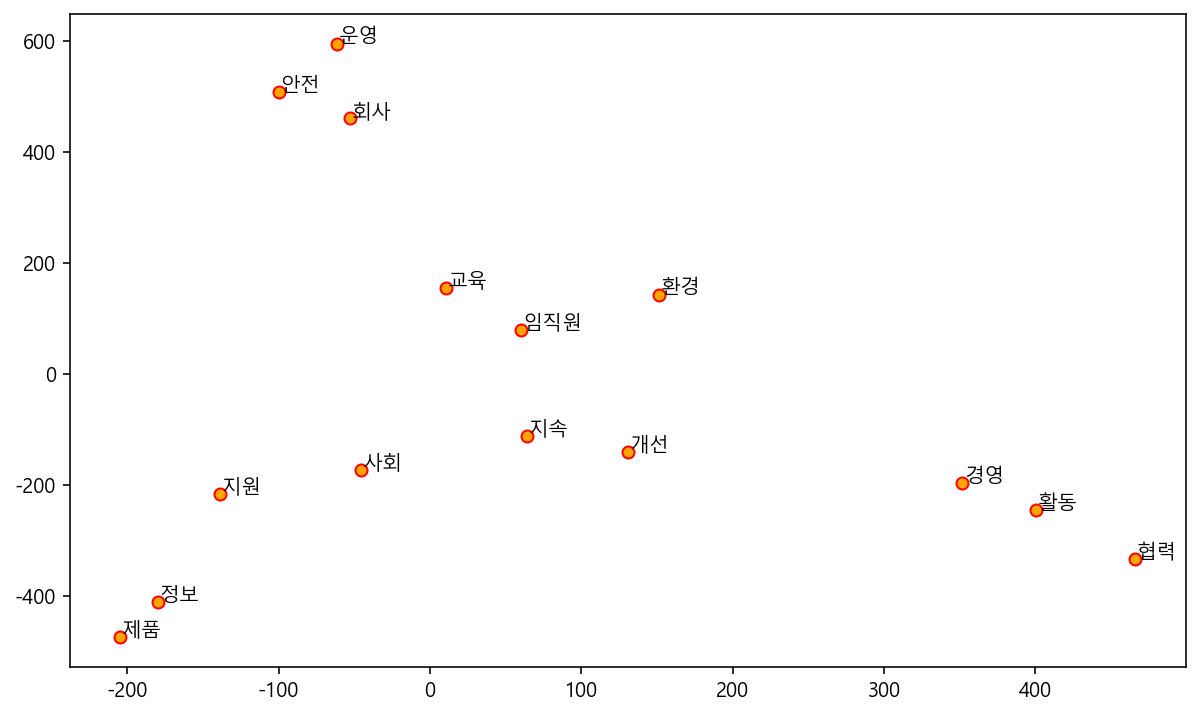

In [26]:
visualize_vectors(word_vectors, vocab)